# **Tugas No.9 Hal 445 Teknik Pemodelan dan Simulasi**

Develop a fire simulation in which every cell in a 17 x 17 grid has a tree and only the middle cell's tree is on fire initially. Do not consider the posibility of lightning or tree growth. The simulaton should have a parameter for *burnProbability*, which is the probability that a tree adjacent to a burning tree catches fire. The function should return the percent of the forest burned. The program should run eight experiments with *burnProbability* = 10%, 20%, 30%, ..., and 90% and should conduct each experiment 10 times. Also, have the code determine the average percent burned for each probability. Plot the data and fit a curve to the data.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML
from math import *
from random import *
from scipy.optimize import curve_fit

matplotlib.rc('animation', html='html5')

## Developing Function

### Constants

Grid-site values:
- EMPTY (0) - empty
- TREE (1) - non-burning tree
- BURNING (2) - burning tree

probTree = probability of grid site occupied by tree (value 1);i.e., tree density

burnProbability = probability that a tree adjacent to a burning tree catches fire

In [3]:
global EMPTY, TREE, BURNING
EMPTY = 0
TREE = 1
BURNING = 2

### Init Forest

pre:
- n is the size (number of rows or column) of the square grid and is positive.
- probTree is the probability that a site is initially occupied by tree.
- the middle cell's tree is on fire initially

post:
- A grid as described above was returned

In [4]:
def initForest(probTree):
  n = 17
  forest = np.zeros((n, n))
  for i in range(0, n):
    for j in range(0, n):
      if (random() < probTree):
        forest[i, j] = TREE
      else:
        forest[i, j] = EMPTY
  forest[8, 8] = BURNING
  return forest

### Spread

An empty cell remains empty. A burning cell becomes empty. If a neighbor to north, east, south, or west of a tree is burning, then the tree does not burn with a probability of probImmune.

In [5]:
def spread(site, N, E, S, W, burnProbability):
  if (site == EMPTY):
    newSite = EMPTY
  else:
    if (site == BURNING):
      newSite = EMPTY
    else:
      if (N == BURNING or E == BURNING or S == BURNING or W == BURNING):
        if (random() < burnProbability):
          newSite = BURNING
        else:
          newSite = TREE
      else:
        newSite = TREE
  return newSite

### Reflecting Lat

Pre: lat is grid

Post: A grid extended one cell in each direction with periodic boundary conditions was returned.

In [6]:
def reflectingLat(lat):
  latNS = np.row_stack((lat[0], lat, lat[-1]))
  return np.column_stack((latNS[:, 0], latNS, latNS[:, -1]))

### Apply Extended

Function returns a matrix of applications of fucntion spread[site, N, E, S, W, burningProb] to each element (site) of extended matrix latExtended except for the first and last rows and columns

In [7]:
def applyExtended(latExt, burnProbability):
  n = latExt.shape[0] - 2
  newLat = np.zeros((n, n))

  for i in range(1, n + 1):
    for j in range(1, n + 1):
      site = latExt[i, j]
      N = latExt[i - 1, j]
      E = latExt[i, j + 1]
      S = latExt[i + 1, j]
      W = latExt[i, j - 1]
      newLat[i - 1, j - 1] = spread(site, N, E, S, W, burnProbability)
  return newLat

### Fire

Pre:
- probTree is the probability that a site is initially occupied by tree.

- burnProbability = probability that a tree adjacent to a burning tree catches fire

- t is the number of time steps.

- spread is the function for the updating rules at each grid point.

Post:
- A list of the initial grid and the grid at each time step was returned.

In [8]:
def fire(probTree, burnProbability, t):
  forest = initForest(probTree)

  # Perform simulation
  grids = np.zeros((t + 1, 17, 17))
  grids[0, :, :] = forest
  for i in range(1, t + 1):
    forest = reflectingLat(forest)
    forest = applyExtended(forest, burnProbability)
    grids[i, :, :] = forest
  return grids

### Set up formatting for the movie files

In [9]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

### Make Color Grid

Function to display a list of grids with cell values colored as follows:
- EMPTY -> yellow,
- TREE -> green,
- BURNING -> burnt orange

In [10]:
def makeColorGrid(grid):
  n = grid.shape[0]
  colorGrid = np.zeros((n, n, 3))
  colorGrid[:, :, 0] = 1
  colorGrid[:, :, 1] = 1
  for i in range(0, n):
    for j in range(0, n):
      if (grid[i, j] == TREE):
        colorGrid[i, j, 0] = 0.1
        colorGrid[i, j, 1] = 0.75
        colorGrid[i, j, 2] = 0.02
      if (grid[i, j] == BURNING):
        colorGrid[i, j, 0] = 0.6
        colorGrid[i, j, 1] = 0.2
        colorGrid[i, j, 2] = 0.1
  return colorGrid

### Visualize Function

In [11]:
def visualize(grids):
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(makeColorGrid(grids[0, :, :]), animated=True)

    # The animation function: called to produce a frame for each generation.
    def updatefig(i, *args):
        im.set_array(makeColorGrid(grids[i, :, :]))
        return im,

    grid_ani = animation.FuncAnimation(fig, updatefig, save_count=len(grids), interval=50, blit=False)
    
    plt.show()
    return HTML(grid_ani.to_html5_video())

### Count Tree

In [12]:
def count_ones(arr):
    count = 0
    for row in arr:
        for val in row:
            if val == 1:
                count += 1
    return count

## Simulation

All of the simulation use probTree of 70%. Each simulation will be run 10 times

In [13]:
probTree = 0.7
avgPercentBurned = []
x_axis = []

### 1. burnProbability = 10%

In [14]:
burnProbability = 0.1
x_axis.append(burnProbability)

percentBurned = []
for i in range(10):
    grids = fire(probTree, burnProbability, 50)
    before = count_ones(grids[0])
    after = count_ones(grids[-1])
    percentBurned.append((before - after) / before)

avgPercentBurned.append(sum(percentBurned) / len(percentBurned))

print("Average percent burned: ", avgPercentBurned[-1])
    

Average percent burned:  0.001944706215264376


### 2. burnProbability = 20%

In [15]:
burnProbability = 0.2
x_axis.append(burnProbability)

percentBurned = []
for i in range(10):
    grids = fire(probTree, burnProbability, 50)
    before = count_ones(grids[0])
    after = count_ones(grids[-1])
    percentBurned.append((before - after) / before)

avgPercentBurned.append(sum(percentBurned) / len(percentBurned))

print("Average percent burned: ", avgPercentBurned[-1])

Average percent burned:  0.003847434884603658


### 3. burnProbability = 30%

In [16]:
burnProbability = 0.3
x_axis.append(burnProbability)

percentBurned = []
for i in range(10):
    grids = fire(probTree, burnProbability, 50)
    before = count_ones(grids[0])
    after = count_ones(grids[-1])
    percentBurned.append((before - after) / before)

avgPercentBurned.append(sum(percentBurned) / len(percentBurned))

print("Average percent burned: ", avgPercentBurned[-1])

Average percent burned:  0.006726153455264922


### 4. burnProbability = 40%

In [17]:
burnProbability = 0.4
x_axis.append(burnProbability)

percentBurned = []
for i in range(10):
    grids = fire(probTree, burnProbability, 50)
    before = count_ones(grids[0])
    after = count_ones(grids[-1])
    percentBurned.append((before - after) / before)

avgPercentBurned.append(sum(percentBurned) / len(percentBurned))

print("Average percent burned: ", avgPercentBurned[-1])

Average percent burned:  0.02014333027380335


### 5. burnProbability = 50%

In [18]:
burnProbability = 0.5
x_axis.append(burnProbability)

percentBurned = []
for i in range(10):
    grids = fire(probTree, burnProbability, 50)
    before = count_ones(grids[0])
    after = count_ones(grids[-1])
    percentBurned.append((before - after) / before)

avgPercentBurned.append(sum(percentBurned) / len(percentBurned))

print("Average percent burned: ", avgPercentBurned[-1])

Average percent burned:  0.01674134187088109


### 6. burnProbability = 60%

In [19]:
burnProbability = 0.6
x_axis.append(burnProbability)

percentBurned = []
for i in range(10):
    grids = fire(probTree, burnProbability, 50)
    before = count_ones(grids[0])
    after = count_ones(grids[-1])
    percentBurned.append((before - after) / before)

avgPercentBurned.append(sum(percentBurned) / len(percentBurned))

print("Average percent burned: ", avgPercentBurned[-1])

Average percent burned:  0.08379598937394175


### 7. burnProbability = 70%

In [20]:
burnProbability = 0.7
x_axis.append(burnProbability)

percentBurned = []
for i in range(10):
    grids = fire(probTree, burnProbability, 50)
    before = count_ones(grids[0])
    after = count_ones(grids[-1])
    percentBurned.append((before - after) / before)

avgPercentBurned.append(sum(percentBurned) / len(percentBurned))

print("Average percent burned: ", avgPercentBurned[-1])

Average percent burned:  0.1508401013720628


### 8. burnProbability = 80%

In [21]:
burnProbability = 0.8
x_axis.append(burnProbability)

percentBurned = []
for i in range(10):
    grids = fire(probTree, burnProbability, 50)
    before = count_ones(grids[0])
    after = count_ones(grids[-1])
    percentBurned.append((before - after) / before)

avgPercentBurned.append(sum(percentBurned) / len(percentBurned))

print("Average percent burned: ", avgPercentBurned[-1])

Average percent burned:  0.22305240921433356


### 9. burnProbability = 90%

In [22]:
burnProbability = 0.9
x_axis.append(burnProbability)

percentBurned = []
for i in range(10):
    grids = fire(probTree, burnProbability, 50)
    before = count_ones(grids[0])
    after = count_ones(grids[-1])
    percentBurned.append((before - after) / before)

avgPercentBurned.append(sum(percentBurned) / len(percentBurned))

print("Average percent burned: ", avgPercentBurned[-1])

Average percent burned:  0.7236599344319549


## Plot & Fit a Curve Average Percent Burned for Each Probability

Text(0, 0.5, 'Average Percent Burned')

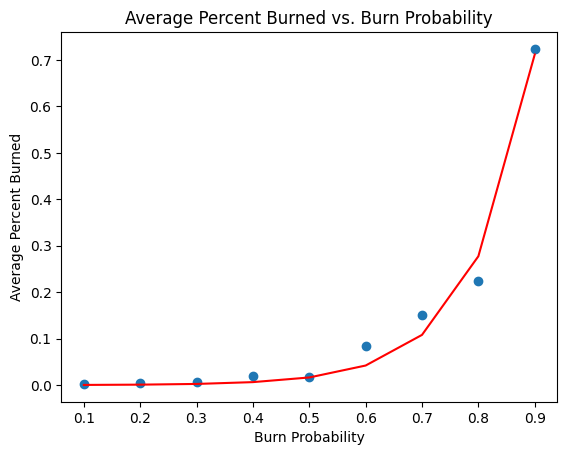

In [23]:
def exponential_func(x, a, b):
    return a * np.exp(b * x)

popt, pcov = curve_fit(exponential_func, x_axis, avgPercentBurned)

plt.scatter(x_axis, avgPercentBurned)
plt.plot(x_axis, exponential_func(np.array(x_axis), *popt), color='red', label='Fitted Curve')

plt.title('Average Percent Burned vs. Burn Probability')
plt.xlabel('Burn Probability')
plt.ylabel('Average Percent Burned')